# Hexagonal vs. Square Kernels

This notebook outlines differences between hexagonal and square convolution kernels and provides a benchmark comparison of the HexagDLy implementatiopn in contrast to standard square kernels in PyTorch.

In [1]:
import hexagdly
from hexagdly_tools import plot_hextensor, plot_squaretensor
from example_utils import toy_data, toy_dataset, model

import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import timeit

By comparing hexagonal and square kernels that cover equal numbers of neighbouring pixels, one can see that a square kernel requires more parameters. This means that the *net number* of computations required to perform a square convolution operation is higher than for a comparable hexagonal operation.
However, the implementation of a hexagonal convolution in HexagDLy combines multiple square-grid operations which in sum are computationally (much) more expensive than using standard square kernel convolutions from PyTorch, as seen in the example below:

In [2]:
hexconv = hexagdly.Conv2d(3, 1, 1, 1)
squareconv = nn.Conv2d(3, 1, 3, 1, 1)

tensor = torch.rand(10, 3, 100, 100)

print('\nHexconv:')
%timeit -n 100 hexconv(tensor)

print('\nSquareconv:')
%timeit -n 100 squareconv(tensor)


Hexconv:
31.3 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Squareconv:
22.1 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


But this only makes square kernels excel in speed on a one-to-one comparison. If you have a hexagonally sampled data set and want to resample it to a square grid e.g. via interpolation or rebinning, not only will you have to invest computation resources for the pre-processing itself, but you will very likely also have to increase the resolution to reduce sampling effects. Increasing the resolution by a factor of $4$, i.e. sampling one hexagonal pixel with $2\times2$ square pixels already yields runtimes comparable to the ones for hexagonal convolutions with HexagDLy, if run on a CPU (this is NOT true if run on a GPU!):

In [3]:
tensor2 = torch.rand(10, 3, 200, 200)
print('\nSquareconv large:')
%timeit -n 100 squareconv(tensor2)


Squareconv large:
27.7 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Furthermore, as the upsampling of data to higher resolutions scales the features and shapes in the data, a square-kernel CNN has to have more layers or larger kernels compared a hex-kernel CNN to have the same receptive fields.

One far more important aspect is the amount of distortion or sampling artefacts that are introduced by a re-sampling method. Therefore, the performance a certain CNN model can reach over time / training epochs is the phase-space to benchmark.

For this benchmark, we use hexagonally sampled images of hexagonal structures (see the notebook 'hexagdly_cnn_example' for details) and the according re-sampled square-grid images:

<IPython.core.display.Javascript object>


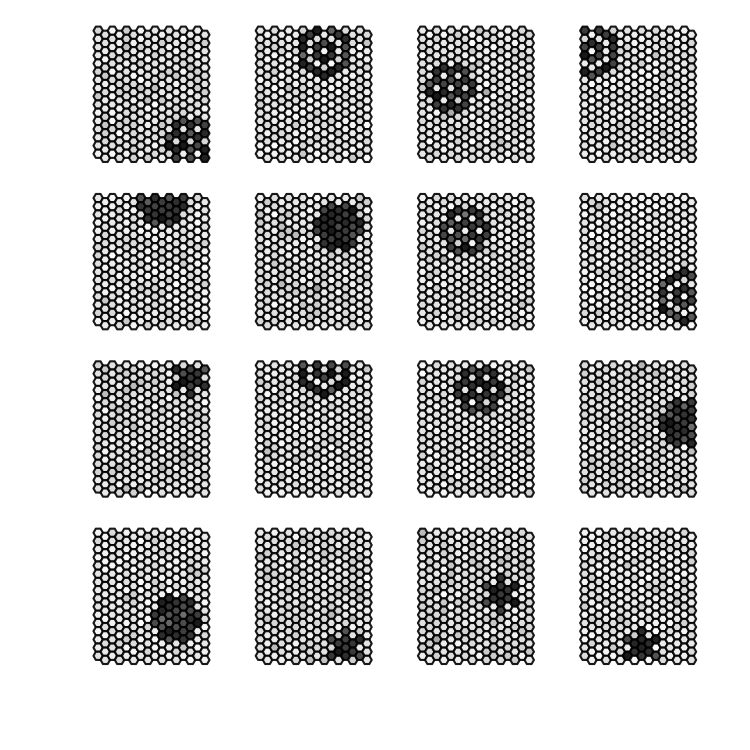

Input not given as pytorch tensor! Continuing...


<IPython.core.display.Javascript object>


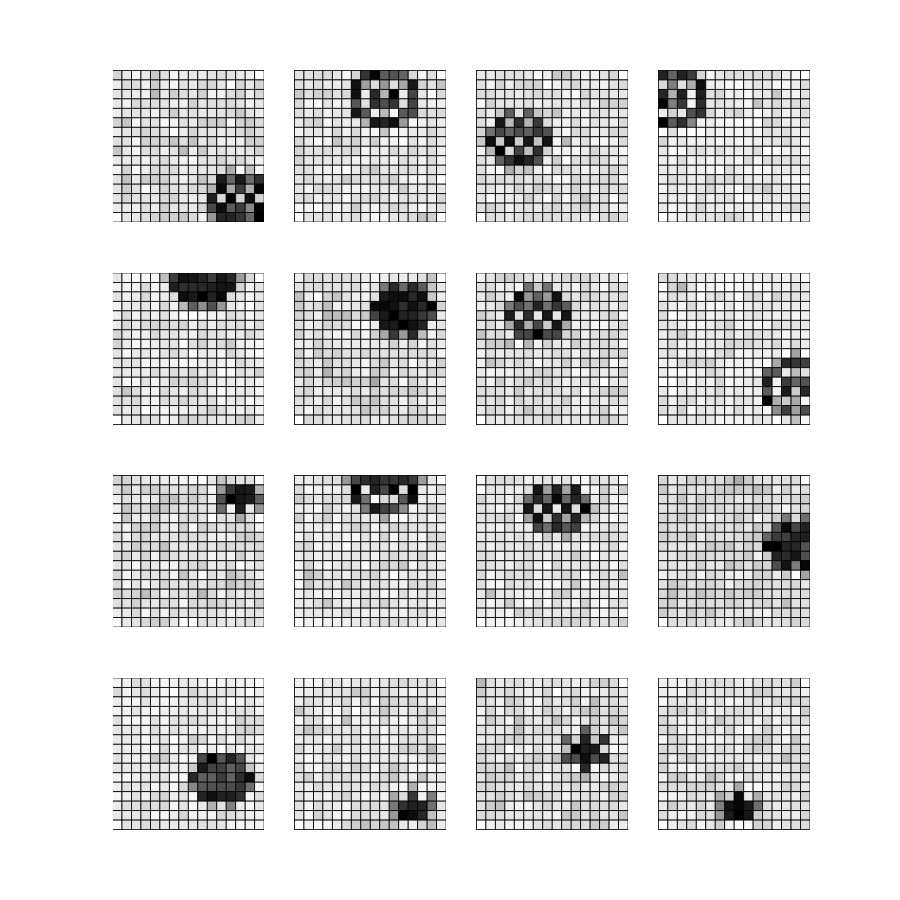

Input not given as pytorch tensor! Continuing...


<IPython.core.display.Javascript object>


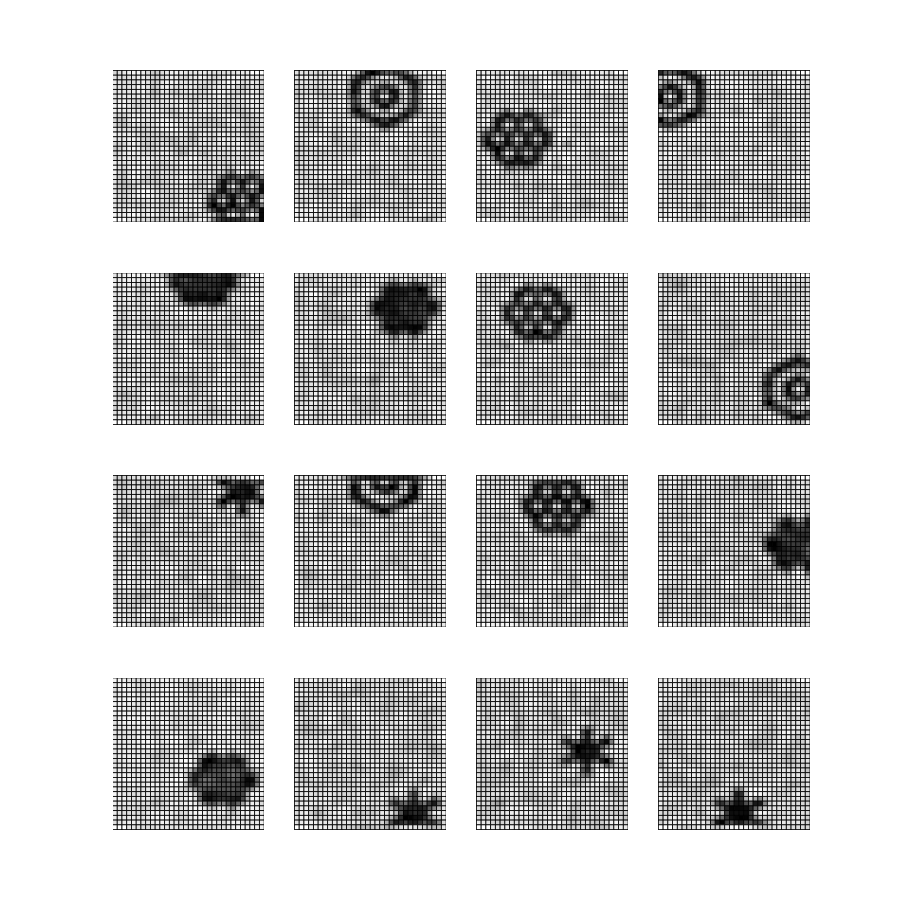

In [4]:
%matplotlib notebook
shape_list = ['snowflake_2', 'snowflake_3', 'snowflake_4', 'double_hex']

val_data = toy_dataset(shape_list, 32, noisy=0.1)
val_data.create()

plot_hextensor(val_data.to_torch_tensor(), image_range=(0,16), channel_range=(0,None), figname='hex_val_examples')
hex_val_dataloader = val_data.to_dataloader()

val_data.convert_to_square(scale=1, method='cubic')
plot_squaretensor(val_data.square_image_data, image_range=(0,16), channel_range=(0,None), figname='square_val_examples_scale=1')
square_val_dataloader = val_data.to_dataloader(sampling='square')

val_data.convert_to_square(scale=2, method='cubic')
plot_squaretensor(val_data.square_image_data, image_range=(0,16), channel_range=(0,None), figname='square_val_examples_scale=2')
large_square_val_dataloader = val_data.to_dataloader(sampling='square')


train_data = toy_dataset(shape_list, 128)
train_data.create()
train_data.convert_to_square(scale=1, method='cubic')
hex_train_dataloader = train_data.to_dataloader()
square_train_dataloader = train_data.to_dataloader(sampling='square')

train_data.convert_to_square(scale=2, method='cubic')
large_square_train_dataloader = train_data.to_dataloader(sampling='square')

Depending on the chosen sampling method and scale, one can easily see sampling artefacts.

The next step is to set up a small CNN model with hexagonal kernels and a second one where the hexagonal convolution and pooling operations are replaced with standard square kernel operations. The main difference is that the square  kernels will include two additional second-next-neighbour pixels while the CNNs have almost the same number of tunable parameters to create a model.

In [5]:
class fc(nn.Module):
    def __init__(self, in_features, out_features):
        super(fc, self).__init__()
        self.ops = nn.Sequential(nn.Linear(in_features, out_features),
                                 nn.ReLU())
    def forward(self, input):
        return self.ops(input)


class hex_model(nn.Module):
    def __init__(self, nout):
        super(hex_model, self).__init__()
        self.name = 'hex_model'
        self.hexconv_1 = hexagdly.Conv2d(1, 2, 1, 1, bias=True)
        self.hexpool = hexagdly.MaxPool2d(1, 2)
        self.hexconv_2 = hexagdly.Conv2d(2, 4, 1, 1, bias=True)

        self.fc = nn.Sequential(fc(256, 64),
                                nn.Dropout(0.5),
                                fc(64, 16),
                                nn.Linear(16, nout))

    def forward(self, x):
        x = self.hexconv_1(x)
        x = F.relu(x)
        x = self.hexpool(x)
        x = self.hexconv_2(x)
        x = F.relu(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x
 

class square_model(nn.Module):
    def __init__(self, nout):
        super(square_model, self).__init__()
        self.name = 'square_model'
        self.squareconv_1 = nn.Conv2d(1, 2, 3, 1, 1, bias=True)
        self.squarepool = nn.MaxPool2d(2, 2)
        self.squareconv_2 = nn.Conv2d(2, 4, 3, 1, 1, bias=True)

        self.fc = nn.Sequential(fc(256, 64),
                                nn.Dropout(0.5),
                                fc(64, 16),
                                nn.Linear(16, nout))

    def forward(self, x):
        x = self.squareconv_1(x)
        x = F.relu(x)
        x = self.squarepool(x)
        x = self.squareconv_2(x)
        x = F.relu(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

class large_square_model(nn.Module):
    def __init__(self, nout):
        super(large_square_model, self).__init__()
        self.name = 'large_square_model'
        self.squareconv_1 = nn.Conv2d(1, 8, 3, 1, 1, bias=True)
        self.squarepool = nn.MaxPool2d(2, 2)
        self.squareconv_2 = nn.Conv2d(8, 16, 3, 1, 1, bias=True)
        self.squareconv_3 = nn.Conv2d(16, 32, 3, 1, 1, bias=True)

        self.fc = nn.Sequential(fc(2048, 512),
                                nn.Dropout(0.5),
                                fc(512, 256),
                                nn.Linear(256, nout))

    def forward(self, x):
        x = self.squareconv_1(x)
        x = F.relu(x)
        x = self.squarepool(x)
        x = self.squareconv_2(x)
        x = F.relu(x)
        x = self.squarepool(x)
        x = self.squareconv_3(x)
        x = F.relu(x)
        x = x.view(-1, 2048)
        x = self.fc(x)
        return x

 The training and validation data are loaded into the two models and the CNNs are trained for a few epochs:

In [6]:
epochs = 10

t0h = time.time()
hex_hex_net = hex_model(len(shape_list))
hex_hex_model = model(hex_train_dataloader, hex_val_dataloader, hex_hex_net, epochs=epochs)
hex_hex_model.train()
t1h = time.time()

Epoch 1
epoch: 1 (0.250) training -    16 batches -> mean loss: 1.392, lr: 0.005, mean acc.: 21.88 %
epoch: 1 (0.500) training -    32 batches -> mean loss: 1.396, lr: 0.005, mean acc.: 21.09 %
epoch: 1 (0.750) training -    48 batches -> mean loss: 1.389, lr: 0.005, mean acc.: 21.88 %
epoch: 1 (1.000) training -    64 batches -> mean loss: 1.388, lr: 0.005, mean acc.: 24.22 %
epoch: 1 (0.250) train_lc -    16 batches -> mean loss: 1.374, lr: 0.005, mean acc.: 32.03 %
epoch: 1 (0.500) train_lc -    32 batches -> mean loss: 1.380, lr: 0.005, mean acc.: 20.31 %
epoch: 1 (0.750) train_lc -    48 batches -> mean loss: 1.371, lr: 0.005, mean acc.: 30.47 %
epoch: 1 (1.000) train_lc -    64 batches -> mean loss: 1.359, lr: 0.005, mean acc.: 39.06 %
epoch: 1 (1.000) val_lc -    16 batches -> mean loss: 1.387, lr: 0.005, mean acc.: 25.00 %
Epoch 2
epoch: 2 (1.250) training -    16 batches -> mean loss: 1.341, lr: 0.005, mean acc.: 47.66 %
epoch: 2 (1.500) training -    32 batches -> mean loss: 

epoch: 10 (10.000) train_lc -    64 batches -> mean loss: 0.073, lr: 0.005, mean acc.: 98.44 %
epoch: 10 (10.000) val_lc -    16 batches -> mean loss: 0.250, lr: 0.005, mean acc.: 89.84 %


In [7]:
t0s = time.time()
square_square_net = square_model(len(shape_list))
square_square_model = model(square_train_dataloader, square_val_dataloader, square_square_net, epochs=epochs)
square_square_model.train()
t1s = time.time()

Epoch 1
epoch: 1 (0.250) training -    16 batches -> mean loss: 1.404, lr: 0.005, mean acc.: 28.12 %
epoch: 1 (0.500) training -    32 batches -> mean loss: 1.398, lr: 0.005, mean acc.: 27.34 %
epoch: 1 (0.750) training -    48 batches -> mean loss: 1.395, lr: 0.005, mean acc.: 22.66 %
epoch: 1 (1.000) training -    64 batches -> mean loss: 1.393, lr: 0.005, mean acc.: 17.19 %
epoch: 1 (0.250) train_lc -    16 batches -> mean loss: 1.390, lr: 0.005, mean acc.: 22.66 %
epoch: 1 (0.500) train_lc -    32 batches -> mean loss: 1.386, lr: 0.005, mean acc.: 26.56 %
epoch: 1 (0.750) train_lc -    48 batches -> mean loss: 1.389, lr: 0.005, mean acc.: 25.78 %
epoch: 1 (1.000) train_lc -    64 batches -> mean loss: 1.394, lr: 0.005, mean acc.: 21.09 %
epoch: 1 (1.000) val_lc -    16 batches -> mean loss: 1.388, lr: 0.005, mean acc.: 25.00 %
Epoch 2
epoch: 2 (1.250) training -    16 batches -> mean loss: 1.383, lr: 0.005, mean acc.: 32.03 %
epoch: 2 (1.500) training -    32 batches -> mean loss: 

epoch: 10 (10.000) train_lc -    64 batches -> mean loss: 1.374, lr: 0.005, mean acc.: 33.59 %
epoch: 10 (10.000) val_lc -    16 batches -> mean loss: 1.381, lr: 0.005, mean acc.: 27.34 %


In [8]:
t0ls = time.time()
large_square_net = large_square_model(len(shape_list))
large_s_model = model(large_square_train_dataloader, large_square_val_dataloader, large_square_net, epochs=epochs)
large_s_model.train(lr=0.005)
t1ls = time.time()

Epoch 1
epoch: 1 (0.250) training -    16 batches -> mean loss: 1.390, lr: 0.005, mean acc.: 21.88 %
epoch: 1 (0.500) training -    32 batches -> mean loss: 1.390, lr: 0.005, mean acc.: 23.44 %
epoch: 1 (0.750) training -    48 batches -> mean loss: 1.389, lr: 0.005, mean acc.: 20.31 %
epoch: 1 (1.000) training -    64 batches -> mean loss: 1.389, lr: 0.005, mean acc.: 21.88 %
epoch: 1 (0.250) train_lc -    16 batches -> mean loss: 1.386, lr: 0.005, mean acc.: 25.00 %
epoch: 1 (0.500) train_lc -    32 batches -> mean loss: 1.385, lr: 0.005, mean acc.: 23.44 %
epoch: 1 (0.750) train_lc -    48 batches -> mean loss: 1.392, lr: 0.005, mean acc.: 21.88 %
epoch: 1 (1.000) train_lc -    64 batches -> mean loss: 1.394, lr: 0.005, mean acc.: 21.09 %
epoch: 1 (1.000) val_lc -    16 batches -> mean loss: 1.388, lr: 0.005, mean acc.: 19.53 %
Epoch 2
epoch: 2 (1.250) training -    16 batches -> mean loss: 1.386, lr: 0.005, mean acc.: 24.22 %
epoch: 2 (1.500) training -    32 batches -> mean loss: 

epoch: 10 (10.000) train_lc -    64 batches -> mean loss: 1.227, lr: 0.005, mean acc.: 35.94 %
epoch: 10 (10.000) val_lc -    16 batches -> mean loss: 1.164, lr: 0.005, mean acc.: 41.41 %


While the training of the hex_model takes quite some more time that the training of the square model, the learning curves show clearly that the hexagonal kernels help the CNN to distinguish between the different hexagonal shapes.

<IPython.core.display.Javascript object>


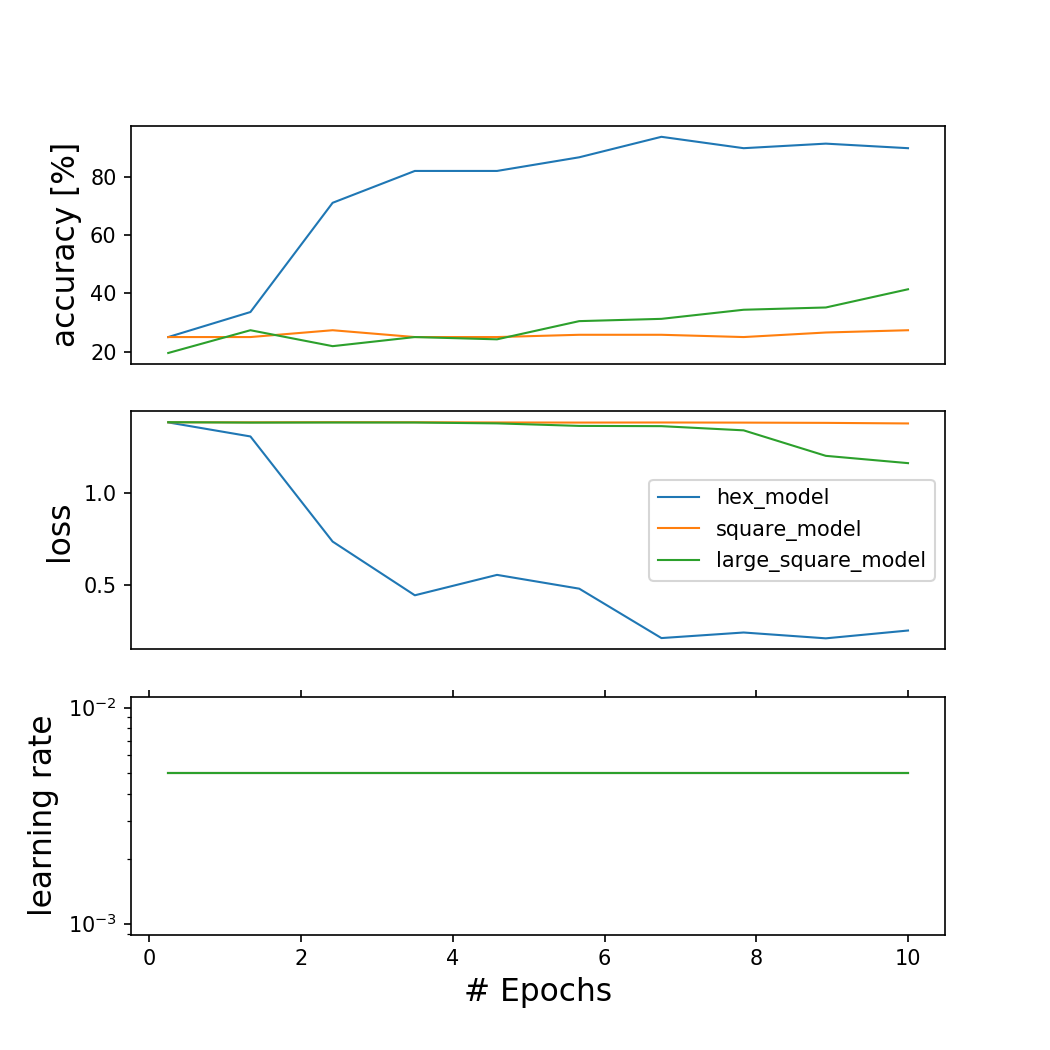

/home/tim/anaconda3/envs/pt-1/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Time needed to train 10 epochs:
Hex CNN benchmark: 12.179 s
Square CNN benchmark: 8.395 s 
Large Square CNN benchmark: 25.348 s


In [9]:
hex_hex_model.plot_lc()
square_square_model.plot_lc()
large_s_model.plot_lc()
print('Time needed to train',epochs,'epochs:')
print('Hex CNN benchmark:', round(t1h-t0h,3),
      's\nSquare CNN benchmark:', round(t1s-t0s,3),'s',
      '\nLarge Square CNN benchmark:', round(t1ls-t0ls,3),'s')